<a href="https://colab.research.google.com/github/conniedeng303/team-glycerin/blob/main/Model_Training_Inception_(Current_Highest)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Simple Starter Code for the AJL Competition

@Cindy Deng

---


Hi! This starter code is designed to help you get familiar with basic Kaggle operations and guide you through the basic workflow of a machine learning project.

The code outlines essential steps including data loading, preprocessing, model building, training, and generating predictions. Each section serves as a foundation, but there are many ways to enhance each step to improve your final model's accuracy. Feel free to experiment with different data augmentation techniques, model architectures, and tuning methods to optimize your final results! Some amazing tutorials are available through your AI Studio course in Canvas / in the 'Resource' section of this Kaggle competition.

Good luck and have fun!

---

## 1. Import Necessary Libraries

In [ ]:
# 1. Import Necessary Libraries
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# Explanation:
# - pandas and numpy: for data manipulation
# - sklearn: for splitting data and encoding labels
# - tensorflow.keras: for building and training the neural network

## 2. Load Data

Make sure to verify the file paths if you're running on a different platform.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
train_path = "/content/drive/MyDrive/VIR_AJL_Team_Glycerin/Dermatology_Dataset/bttai-ajl-2025_unzipped/train.csv"
test_path = "/content/drive/MyDrive/VIR_AJL_Team_Glycerin/Dermatology_Dataset/bttai-ajl-2025_unzipped/test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df['md5hash'] = train_df['md5hash'].astype(str) + '.jpg'
test_df['md5hash'] = test_df['md5hash'].astype(str) + '.jpg'
train_df['file_path'] = train_df['label'] + '/' + train_df['md5hash']

Mounted at /content/drive


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/VIR_AJL_Team_Glycerin/Dermatology_Dataset/bttai-ajl-2025_unzipped/train.csv'

In [ ]:
# Check the first few rows to understand the structure
print(train_df.head())

                                md5hash  fitzpatrick_scale  \
0  fd06d13de341cc75ad679916c5d7e6a6.jpg                  4   
1  a4bb4e5206c4e89a303f470576fc5253.jpg                  1   
2  c94ce27e389f96bda998e7c3fa5c4a2e.jpg                  5   
3  ebcf2b50dd943c700d4e2b586fcd4425.jpg                  3   
4  c77d6c895f05fea73a8f3704307036c0.jpg                  1   

   fitzpatrick_centaur                             label nine_partition_label  \
0                    4                 prurigo-nodularis     benign-epidermal   
1                    1  basal-cell-carcinoma-morpheiform  malignant-epidermal   
2                    5                            keloid         inflammatory   
3                    3              basal-cell-carcinoma  malignant-epidermal   
4                    1                 prurigo-nodularis     benign-epidermal   

  three_partition_label            qc  ddi_scale  \
0                benign           NaN         34   
1             malignant           Na

## 3. Data Preprocessing


This section demonstrates basic preprocessing techniques. To enhance data quality and model performance, consider incorporating more advanced preprocessing methods.

For further guidance, feel free to take a look at the [Image Preprocessing tutorial](https://colab.research.google.com/drive/1-ItNcRMbZBE6BCwPT-wD8m3YmHqwHxme?usp=sharing)  available in the 'Resources' section of this Kaggle competition.


In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
train_df['encoded_label'] = label_encoder.fit_transform(train_df['label'])

# Split the data into training and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])


#PreProcessing Functions

In [ ]:
#Noise Injection
def add_noise(image):
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1, dtype=tf.float32)
    return image + noise

#Cut Out : cutting out different parts of the image
def cutout(image, mask_size=50):
    h, w = image.shape[0], image.shape[1]
    mask = np.ones((h, w, 3), np.float32)
    y = np.random.randint(h)
    x = np.random.randint(w)
    y1 = np.clip(y - mask_size // 2, 0, h)
    y2 = np.clip(y + mask_size // 2, 0, h)
    x1 = np.clip(x - mask_size // 2, 0, w)
    x2 = np.clip(x + mask_size // 2, 0, w)
    mask[y1:y2, x1:x2] = 0
    return image * mask


#final pre-processing
def combined_preprocessing(image):
    if np.random.rand() < 0.3:
        image = add_noise(image)

    if np.random.rand() < 0.3:
        image = cutout(image)

    return image

In [ ]:
# from PIL import Image


# def load_images(df, base_path, img_size=(299, 299)):
#     images = []
#     labels = []
#     for _, row in df.iterrows():
#         img_path = os.path.join(base_path, row['file_path'])
#         img = Image.open(img_path).resize(img_size)  # Resize images to 299x299
#         img = np.array(img) / 255.0  # Normalize pixel values
#         images.append(img)
#         labels.append(row['encoded_label'])
#     return np.array(images), np.array(labels)

# # Load training images and labels
# base_path = "/content/drive/MyDrive/VIR_AJL_Team_Glycerin/Dermatology_Dataset/bttai-ajl-2025_unzipped"
# train_images, train_labels = load_images(train_data, base_path, img_size=(299, 299))

# train_images_flat = train_images.reshape(train_images.shape[0], -1)

# # Apply SMOTE to generate synthetic samples
# smote = SMOTE()
# train_images_resampled, train_labels_resampled = smote.fit_resample(train_images_flat, train_labels)

# # Reshape back to original image dimensions (299x299)
# train_images_resampled = train_images_resampled.reshape(-1, 299, 299, 3)

# train_images_combined = np.concatenate([train_images, train_images_resampled], axis=0)
# train_labels_combined = np.concatenate([train_labels, train_labels_resampled], axis=0)

# # Convert labels to categorical (one-hot encoding)
# train_labels_combined = to_categorical(train_labels_combined)

# Data Generators

In [ ]:
# Define image data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=combined_preprocessing,
    channel_shift_range=0.05,  # Channel shift range of 0.05
    brightness_range=[0.0, 1.0],
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Define the directory paths
train_dir = '/content/drive/MyDrive/VIR_AJL_Team_Glycerin/Dermatology_Dataset/bttai-ajl-2025_unzipped/train/train'

# Prepare data generators
classes = sorted(train_df['label'].unique())
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_dir,
    x_col='file_path',
    y_col='label',
    classes=classes,
    target_size=(299, 299),  # InceptionV3 expects 299x299 images
    batch_size=32,
    class_mode='categorical',
    validate_filenames=False
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=train_dir,
    x_col='file_path',
    y_col='label',
    classes=classes,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    validate_filenames=False
)


Found 2288 non-validated image filenames belonging to 21 classes.
Found 572 non-validated image filenames belonging to 21 classes.


#Oversampling Minority Classes

In [ ]:
from imblearn.over_sampling import SMOTE

## 4. Build the model


In [ ]:
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model
base_model.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


## 5. Train the Model


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

## 6. Make Predictions on Test Data

In [ ]:

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5) #testing 5 next time

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.1437 - loss: 3.2381 - val_accuracy: 0.2727 - val_loss: 2.4280 - learning_rate: 0.0010
Epoch 2/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.3377 - loss: 2.2901 - val_accuracy: 0.3829 - val_loss: 2.1415 - learning_rate: 0.0010
Epoch 3/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.3973 - loss: 2.0349 - val_accuracy: 0.3969 - val_loss: 2.0309 - learning_rate: 0.0010
Epoch 4/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.4170 - loss: 1.9271 - val_accuracy: 0.3969 - val_loss: 2.0563 - learning_rate: 0.0010
Epoch 5/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.4278 - loss: 1.8367 - val_accuracy: 0.3741 - val_loss: 2.0278 - learning_rate: 0.0010
Epoch 6/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.4534 - loss: 1.8155 - val_accuracy: 0.4283 - val_loss: 1.9675 - learning_rate: 0.0010
Epoch 7/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4608 - loss: 1.7236 - val_accuracy:

## 7. Generate Predictions

In [ ]:
# TODO
# Generate predictions based on the trained model
# Then, save the predictions into a CSV file for submission

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_accuracy:.2f}')

# Prepare test data generator
test_dir = '/content/drive/MyDrive/VIR_AJL_Team_Glycerin/Dermatology_Dataset/bttai-ajl-2025_unzipped/test.csv'
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='/content/drive/MyDrive/VIR_AJL_Team_Glycerin/Dermatology_Dataset/bttai-ajl-2025_unzipped/test/test',
    x_col='md5hash',
    y_col=None,
    target_size=(299, 299),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

# Generate predictions
predictions = model.predict(test_generator)
predicted_labels = [classes[pred.argmax()] for pred in predictions]

# Create submission DataFrame
submission_df = pd.DataFrame({
    'md5hash': test_df['md5hash'].str.replace('.jpg', ''),
    'label': predicted_labels
})

# Save to CSV
submission_df.to_csv('/content/drive/MyDrive/VIR_AJL_Team_Glycerin/Submissions/submission.csv', index=False)

18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - accuracy: 0.4592 - loss: 1.7842
Validation Accuracy: 0.46
Found 1227 validated image filenames.
39/39 ━━━━━━━━━━━━━━━━━━━━ 424s 11s/step


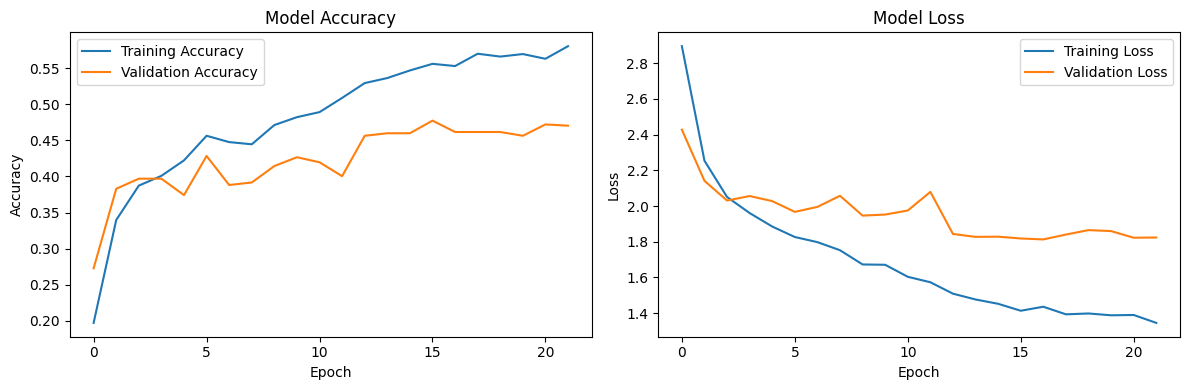

In [ ]:
submission

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()